## Joining gpd.GeoDataFrames with pd.DataFrames

TL;DR: when doing a merge between a geo-dataframe and a dataframe the geo-dataframe must on the "left side" of the merge to retain the geospatial information. 

See geopandas documentation: https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#attribute-joins

Example from today's class:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import and simplify countries shapefile
fp = os.path.join(data_folder_fp, 
                  'ne_50m_admin_0_countries', 
                  'ne_50m_admin_0_countries.shp')

countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()
countries = countries[['admin', 'type', 'geometry']]

# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)

# Import country names CSV
fp = os.path.join(data_folder_fp, 
                  'country_names', 
                  'country_names.csv')

country_names = pd.read_csv(fp)



# -------------------------------------------------------
# Prepare data for merging

# Reproject countries to ensure CRS consistency
countries = countries.to_crs(communities.crs)
assert countries.crs == communities.crs


# Create a dataframe with the number of communities per country
n_comms = (communities.groupby('country')
                      .size()
                      .reset_index(name='n_communities')
          )

n_comms = pd.merge(n_comms,
                   country_names, 
                   how='left', 
                   on='country')

In [2]:
# Inspect data frame
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


In [3]:
# First merge: countries geo-dataframe is on the left side
merge1 = pd.merge(countries, 
                  n_comms,
                  how='inner',
                  on='admin')

print("This is a: ", type(merge1))
merge1.head(3)

This is a:  <class 'geopandas.geodataframe.GeoDataFrame'>


,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133


Notice the output is still a gpd.GeoDataFrame. Since the geospatial information is still interpreted as such, when we plot `merge1` we get a map:

<Axes: >

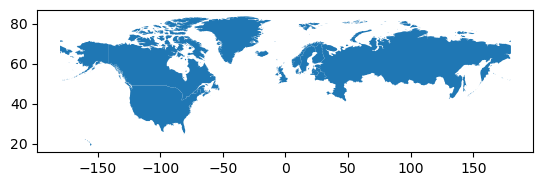

In [4]:
merge1.plot()

In [5]:
# Second merge: countries geo-dataframe is on the right side
merge2 = pd.merge(n_comms,
                  countries, 
                  how='inner',
                  on='admin')

print("This is a: ", type(merge2))
merge2.head(3)

This is a:  <class 'pandas.core.frame.DataFrame'>


,country,n_communities,admin,type,geometry
0,BY,8,Belarus,Sovereign country,"POLYGON ((31.76338 52.10107, 31.57373 52.10811..."
1,CA,7,Canada,Sovereign country,"MULTIPOLYGON (((-132.65552 54.12749, -132.5640..."
2,DK,72,Denmark,Country,"MULTIPOLYGON (((12.56875 55.78506, 12.57119 55..."


Notice that when the geodataframe was on the right, the resulting merge is a plain pandas data frame: the geospatial information is lost. So, when we do `.plot()` we are getting a plot with the numeric data instead of the map.

<Axes: >

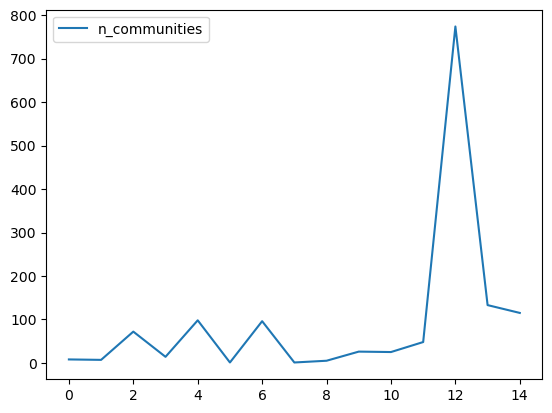

In [6]:
merge2.plot()

So, merge with your geo-df on the left or use the `merge` method called from the geo-df itself. The `geopandas` documentation has a bit more info about this: 
https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#attribute-joins